 # Time series forecasting 
In this notebook I will cover the statistical techniques to do time series forecasting. ( ARIMA , SARIMA)

In [227]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
# The units are in degrees Celsius and there are 3650 observations. 
# The source of the data is credited as the Australian Bureau of Meteorology.

In [4]:
df = pd.read_csv('daily-min-temperatures.csv')

In [5]:
df.head()

Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8

In [6]:
df.describe()

Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000

In [7]:
df.describe(include='O')

Date
count         3650
unique        3650
top     1988-05-25
freq             1

In [8]:
df['date'] = pd.to_datetime(df['Date'], format='%Y-%m')

In [9]:
y = df.set_index('date')

# 1- time plot

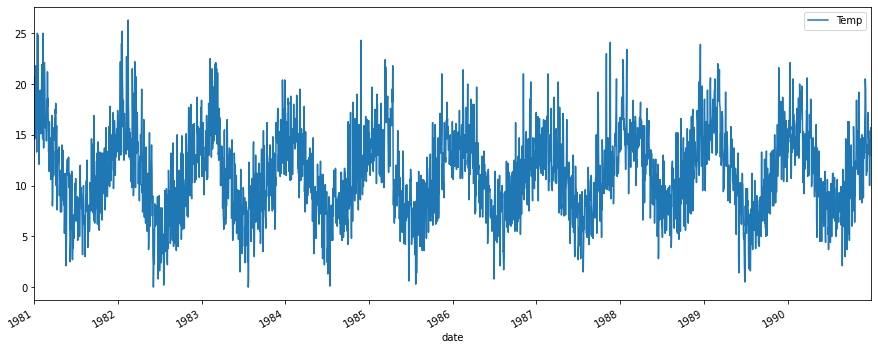

In [10]:
y.plot(figsize=(15, 6))
plt.show()

#### Observations : 
- Looks like there is a seasonality (of period = 1 year )
- trend each semester ( 6 months )
-  ==> Non stationary 

# 2- hist and density plot

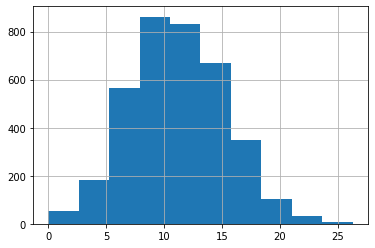

In [11]:
y['Temp'].hist()

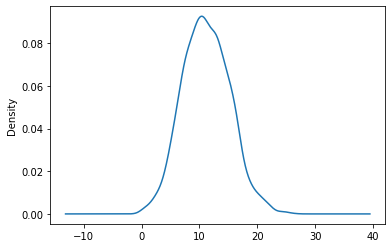

In [12]:
y.Temp.plot(kind='kde')

### Observations: 
- The distribution seems to be gaussian with a mean around 11.

In [13]:
df['year'] = df['Date'].apply(lambda x: x[:4])

In [14]:
# box plot 

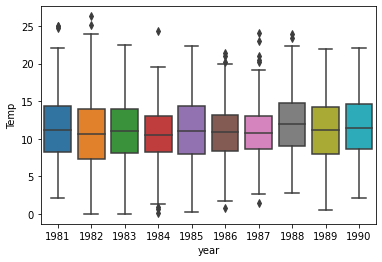

In [15]:
sns.boxplot( df['year'] , df['Temp'] )

### Observations: 
- No apparent trend over the years

In [16]:
df_month = df.copy()

In [17]:
df_month['month'] = df_month['Date'].str[:7]

In [18]:
# see the trend only on 1981 and 1982

In [19]:
df_month = df_month[(df_month['year']=='1981')|(df_month['year']=='1982')]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

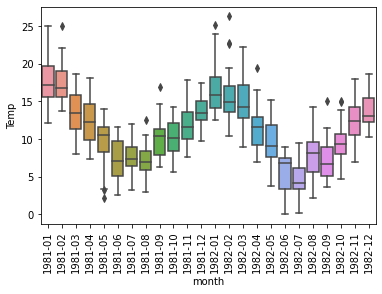

In [20]:
sns.boxplot( df_month['month'] , df_month['Temp'] )
plt.xticks(rotation=90)

- Trend : decreasing temperatures from january to july , increasing temperatures from july to january 
- Seasonality : each year 

In [21]:
df.loc[df.groupby('year')['Temp'].idxmin()]

Date  Temp       date  year
139   1981-05-20   2.1 1981-05-20  1981
520   1982-06-05   0.0 1982-06-05  1982
934   1983-07-24   0.0 1983-07-24  1983
1290  1984-07-14   0.1 1984-07-14  1984
1663  1985-07-23   0.3 1985-07-23  1985
2005  1986-06-30   0.8 1986-06-30  1986
2394  1987-07-24   1.5 1987-07-24  1987
2722  1988-06-16   2.8 1988-06-16  1988
3098  1989-06-28   0.5 1989-06-28  1989
3523  1990-08-27   2.1 1990-08-27  1990

- The temperatures are minimum around may and july ( winter during this period in Australia )

In [22]:
df.loc[df.groupby('year')['Temp'].idxmax()]

Date  Temp       date  year
14    1981-01-15  25.0 1981-01-15  1981
410   1982-02-15  26.3 1982-02-15  1982
768   1983-02-08  22.5 1983-02-08  1983
1425  1984-11-26  24.3 1984-11-26  1984
1530  1985-03-12  22.4 1985-03-12  1985
1870  1986-02-15  21.4 1986-02-15  1986
2512  1987-11-19  24.1 1987-11-19  1987
2905  1988-12-16  23.9 1988-12-16  1988
2980  1989-03-02  22.0 1989-03-02  1989
3295  1990-01-11  22.1 1990-01-11  1990

- The temperatures are max around december and february ( summer during this period in Australia )

# 3- Decomposing the time series into = trend + seasonality + residual component

In [23]:
y

Date  Temp
date                        
1981-01-01  1981-01-01  20.7
1981-01-02  1981-01-02  17.9
1981-01-03  1981-01-03  18.8
1981-01-04  1981-01-04  14.6
1981-01-05  1981-01-05  15.8
...                ...   ...
1990-12-27  1990-12-27  14.0
1990-12-28  1990-12-28  13.6
1990-12-29  1990-12-29  13.5
1990-12-30  1990-12-30  15.7
1990-12-31  1990-12-31  13.0

[3650 rows x 2 columns]

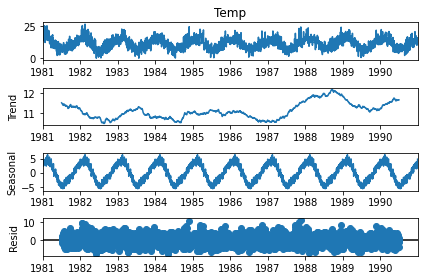

In [24]:
decomposition = seasonal_decompose(y['Temp'], model='additive', freq = 365)
fig = decomposition.plot()
plt.show()

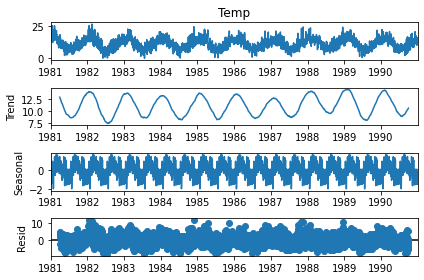

In [25]:
decomposition = seasonal_decompose(y['Temp'], model='additive', freq = 182)
fig = decomposition.plot()
plt.show()

### Observations: 
- season each 1 year
- trend each 6 months

# 4- Stationarity
- statistical properties such as mean, variance remain constant over time

## ACF and PACF plots 
- Confidence intervals are drawn as a cone, they are set to a 95% confidence interval : correlation values outside the cone are significant.

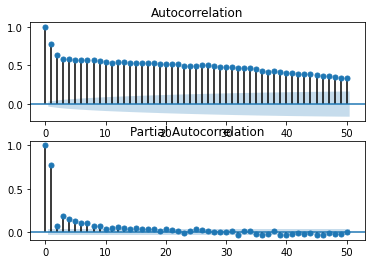

In [26]:
plt.figure()
plt.subplot(211)
plot_acf(y.Temp, ax=plt.gca(), lags = 50)
plt.subplot(212)
plot_pacf(y.Temp, ax=plt.gca(), lags = 50)
plt.show()

- The data is non-stationary : high number of previous observations are correlated with future values.

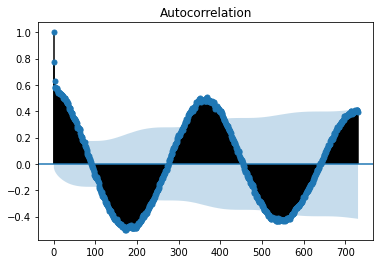

In [27]:
plot_acf(y.Temp, ax=plt.gca(), lags = 730)
plt.show()

- We see that the seasonality is very apparent ==> high correlation each 365 days.
- We see also a trend each 1/2 year ==> continuous values of correlations (no jumps)

## Rolling mean

In [28]:
moving_avg = y.Temp.rolling(12).mean()
moving_std = y.Temp.rolling(12).std()

Text(0.5, 1.0, 'Rolling Mean plot')

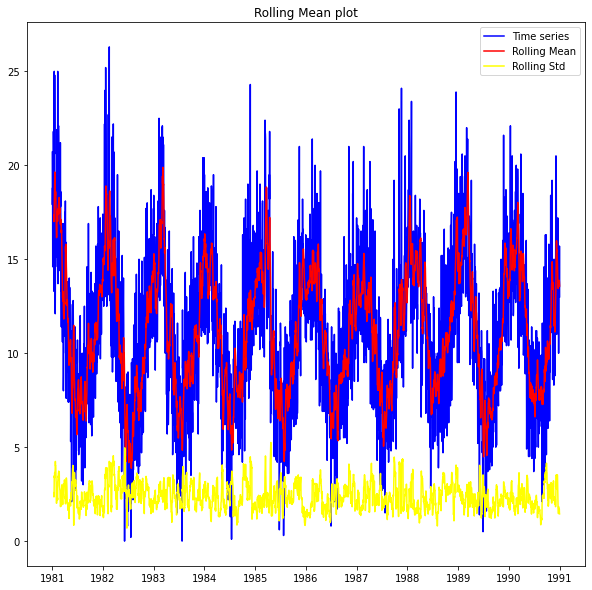

In [29]:
plt.figure(figsize=(10,10))
plt.plot(y.Temp, color='blue',label='Time series')
plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='yellow', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean plot')

- We observe that the rolling mean isn't constant with respect to time (increasing/ decreasing trend) ==> no stationarity

# 5- Make the time series stationary 

## differencing 

In [33]:
y['Temp_diff'] = y['Temp'] - y['Temp'].shift(1)

Text(0.5, 1.0, 'Rolling Mean plot')

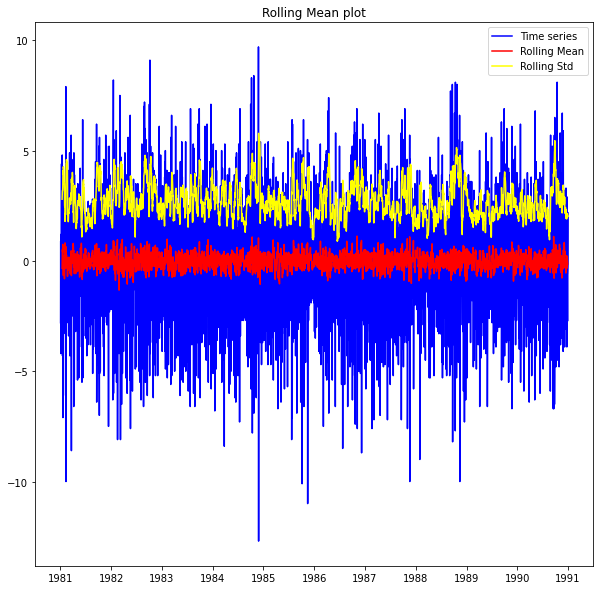

In [34]:
moving_avg_diff = y['Temp_diff'].rolling(12).mean()
moving_std_diff = y['Temp_diff'].rolling(12).std()
plt.figure(figsize=(10,10))
plt.plot(y['Temp_diff'], color='blue',label='Time series')
plt.plot(moving_avg_diff, color='red', label='Rolling Mean')
std = plt.plot(moving_std_diff, color='yellow', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean plot')

- mean and variance constant 

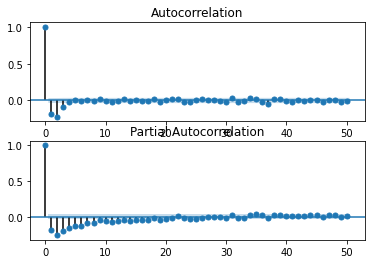

In [35]:
plt.figure()
plt.subplot(211)
plot_acf(y.Temp_diff.dropna(), ax=plt.gca(), lags = 50)
plt.subplot(212)
plot_pacf(y.Temp_diff.dropna(), ax=plt.gca(), lags = 50)
plt.show()

-  The ACF/PACF plots show a quick drop-off in correlation after a small amount of lag between points ==> seems to be stationnary 

## Augmented Dickey-Fuller Test
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis:  (i.e. a very low p-value) stationarity


In [36]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y['Temp_diff'].dropna().values, autolag="t-stat")
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.802822e+01
p-value                        2.681562e-30
#Lags Used                     2.400000e+01
Number of Observations Used    3.624000e+03
Critical Value (1%)           -3.432156e+00
Critical Value (5%)           -2.862338e+00
Critical Value (10%)          -2.567195e+00
dtype: float64


- P value <<< 0.05 ==> Stationary 

# 6- Time series forecasting 

## Autoregressive model

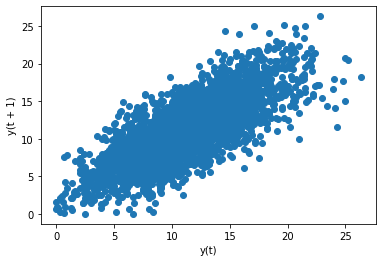

In [37]:
lag_plot(y.Temp)

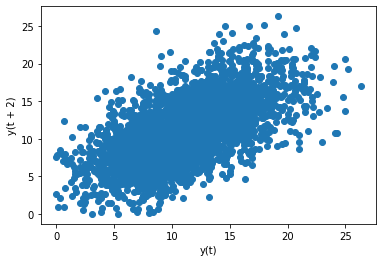

In [38]:
lag_plot(y.Temp,2)

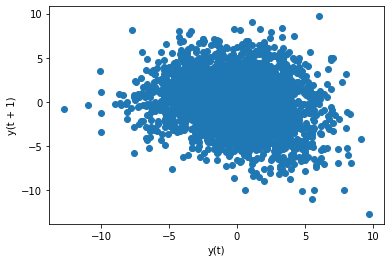

In [39]:
lag_plot(y.Temp_diff)

- Strong relationship 

In [40]:
X = y.Temp
train, test = X[1:len(X)-20], X[len(X)-20:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept    0.555195
Temp.L1      0.589146
Temp.L2     -0.091460
Temp.L3      0.047843
Temp.L4      0.040870
Temp.L5      0.039034
Temp.L6      0.026685
Temp.L7      0.045146
Temp.L8      0.012997
Temp.L9      0.037313
Temp.L10    -0.000492
Temp.L11     0.002807
Temp.L12     0.019100
Temp.L13     0.025107
Temp.L14     0.000342
Temp.L15     0.025506
Temp.L16     0.006716
Temp.L17     0.010597
Temp.L18     0.035408
Temp.L19    -0.009031
Temp.L20     0.023855
Temp.L21     0.019784
Temp.L22     0.012004
Temp.L23    -0.018470
Temp.L24    -0.002770
Temp.L25     0.017614
Temp.L26     0.019980
Temp.L27     0.007790
Temp.L28     0.007798
Temp.L29    -0.001613
dtype: float64


We see that from lag 7 the coefficients are very low, thus we will build 2 models : 
    - 1st with 29 lags 
    - the other with 7 lags
We will compare them.

In [41]:
model2 = AutoReg(train, lags=7)
model2_fit = model2.fit()

In [42]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions2 = model2_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

Test RMSE1: 1.577
Test RMSE2: 1.916


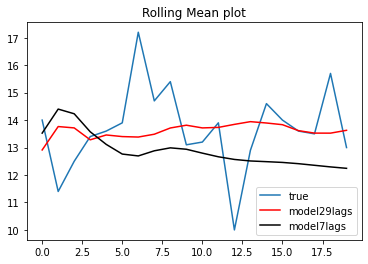

In [43]:
rmse = sqrt(mean_squared_error(test, predictions))
rmse2 = sqrt(mean_squared_error(test, predictions2))
print('Test RMSE1: %.3f' % rmse)
print('Test RMSE2: %.3f' % rmse2)
# plot results
plt.plot(test.values, label='true')
plt.plot(predictions.values, color='red', label='model29lags')
plt.plot(predictions2.values, color='black', label='model7lags')
plt.legend(loc='best')
plt.title('Rolling Mean plot')
plt.show()

let's see if the model meets box jenkins assumptions to use the model 

In [44]:
predictions_train = model_fit.predict(start=29, end=len(train)-1, dynamic=False)

(array([  30.,  162.,  501.,  876., 1094.,  651.,  198.,   71.,   15.,
           2.]),
 array([-7.42725235, -5.64820578, -3.86915921, -2.09011264, -0.31106607,
         1.4679805 ,  3.24702707,  5.02607364,  6.80512021,  8.58416678,
        10.36321335]),
 <a list of 10 Patch objects>)

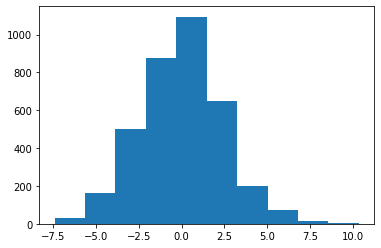

In [45]:
plt.hist(train.iloc[29:] - predictions_train ) 

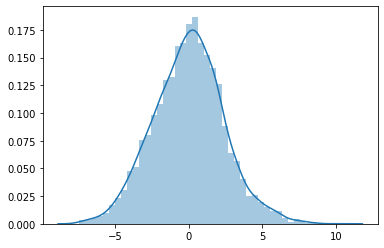

In [46]:
sns.distplot(train.iloc[29:] - predictions_train)

* the error seems to be gaussian 

In [47]:
(train.iloc[29:] - predictions_train).describe()

count    3.600000e+03
mean     1.019382e-14
std      2.397870e+00
min     -7.427252e+00
25%     -1.603664e+00
50%      4.493587e-02
75%      1.545061e+00
max      1.036321e+01
dtype: float64

* mean = 0 and std = 2.4

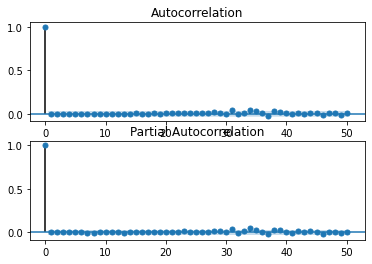

In [48]:
plt.figure()
plt.subplot(211)
plot_acf(train.iloc[29:] - predictions_train, ax=plt.gca(), lags = 50)
plt.subplot(212)
plot_pacf(train.iloc[29:] - predictions_train, ax=plt.gca(), lags = 50)
plt.show()

* no correlation for the error 

no correlations between the errors + gaussian distribution ==> good fit ! 

## ARIMA 

### ACF and PACF

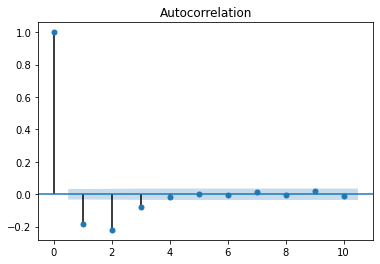

In [65]:
plot_acf(y['Temp_diff'].dropna(), lags=10)
plt.show()

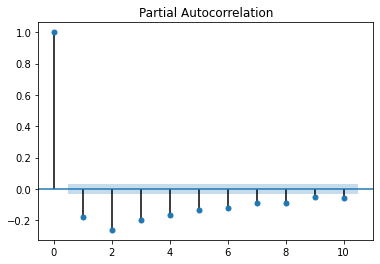

In [66]:
plot_pacf(y['Temp_diff'].dropna(), lags=10)
plt.show()

### Grid search with ARIMA

In [70]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [69]:
p_values = range(0,4)
d_values = [1]
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(y.Temp.values, p_values, d_values, q_values)

ARIMA(0, 1, 0) MSE=6.157
ARIMA(0, 1, 1) MSE=5.813
ARIMA(0, 1, 2) MSE=4.969
ARIMA(0, 1, 3) MSE=4.889
ARIMA(1, 1, 0) MSE=6.013
ARIMA(1, 1, 1) MSE=4.976
ARIMA(1, 1, 2) MSE=4.896
ARIMA(1, 1, 3) MSE=4.890
ARIMA(2, 1, 0) MSE=5.635
ARIMA(2, 1, 1) MSE=4.887
ARIMA(2, 1, 2) MSE=4.889
ARIMA(2, 1, 3) MSE=4.893
ARIMA(3, 1, 0) MSE=5.393
ARIMA(3, 1, 1) MSE=4.888
ARIMA(3, 1, 2) MSE=4.887
ARIMA(3, 1, 3) MSE=4.888
Best ARIMA(2, 1, 1) MSE=4.887


In [73]:
X = y.Temp.values
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

In [106]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3648
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -8384.263
Method:                       css-mle   S.D. of innovations              2.409
Date:                Mon, 24 Aug 2020   AIC                          16778.526
Time:                        11:09:51   BIC                          16809.536
Sample:                             1   HQIC                         16789.570
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.006     -0.179      0.858      -0.013       0.011
ar.L1.D.y      0.4965      0.018     27.345      0.000       0.461       0.532
ar.L2.D.y     -0.1296      0.017     -7.425      0.000      -0.164      -0.095
ma.L1.D.y     -0.9008      0.009   -104.762      0.000      -0.918      -0.884
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9160           -2.0115j            2.7780           -0.1289
AR.2            1.9160           +2.0115j            2.7780            0.1289
MA.1            1.1101           +0.0000j            1.1101            0.0000
-----------------------------------------------------------------------------
"""

### test VS predictions

MSE:  4.8871495785503
MAE:  1.7396645516211648


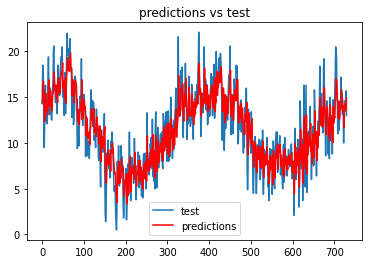

In [79]:
print("MSE: ", mean_squared_error(test, predictions))
print("MAE: ", mean_absolute_error(test, predictions))

plt.plot(test, label='test')
plt.plot(predictions, label= 'predictions', color='red')
plt.legend(loc='best')
plt.title('predictions vs test')
plt.show()

To acheive a better performance we can : 
- leverage exogenous data that can be discriminative (humidity levels ...).
- add a seasonality component.

### Analyzing the residuals 

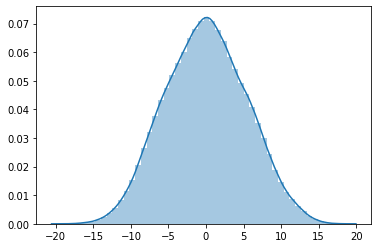

In [80]:
sns.distplot(test - predictions)

In [96]:
preds = list()
for i in predictions:
    preds.append(i[0])
preds = np.array(preds)

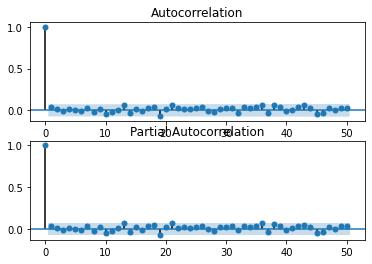

In [98]:
plt.figure()
plt.subplot(211)
plot_acf(test - preds, ax=plt.gca(), lags = 50)
plt.subplot(212)
plot_pacf(test - preds, ax=plt.gca(), lags = 50)
plt.show()

==> White Noise 

# Auto ARIMA

A package that will choose the orders automatically.

In [123]:
from pmdarima.arima import auto_arima

In [136]:
arima_model = auto_arima(y.Temp[:-200])

In [139]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3450
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -7931.888
Date:                Mon, 24 Aug 2020   AIC                          15875.776
Time:                        13:19:27   BIC                          15912.652
Sample:                             0   HQIC                         15888.946
                               - 3450                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0858      0.028      3.033      0.002       0.030       0.141
ar.L1          0.9924      0.002    420.536      0.000       0.988       0.997
ma.L1         -0.3993      0.016    -25.509      0.000      -0.430      -0.369
ma.L2         -0.3271      0.017    -19.063      0.000      -0.361      -0.293
ma.L3         -0.1054      0.016     -6.463      0.000      -0.137      -0.073
sigma2         5.8113      0.132     44.045      0.000       5.553       6.070
===================================================================================
Ljung-Box (Q):                       46.88   Jarque-Bera (JB):                16.20
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 200 ), index= y.Temp[-200:].index)

In [143]:
prediction.columns = ['Predicted_temperatures']

MSE:  9.765652462877375
MAE:  2.399850295308168


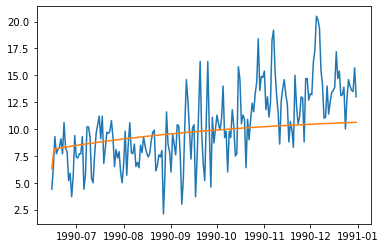

In [148]:
print("MSE: ", mean_squared_error(y.Temp[-200:], prediction))
print("MAE: ", mean_absolute_error(y.Temp[-200:], prediction))
plt.plot(y.Temp[-200:])
plt.plot(prediction)

* Looks like the model that was created manually is better than auto arima 

In [221]:
pred = list()
for i in prediction['Predicted_temperatures']:
    pred.append(i)
pred = np.array(pred)

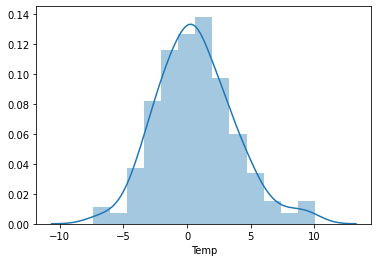

In [224]:
sns.distplot(y.Temp[-200:]- pred)

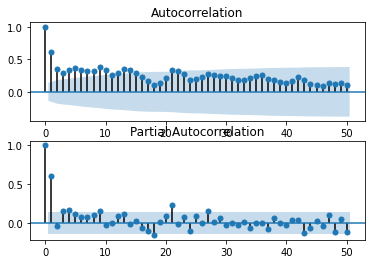

In [225]:
plt.figure()
plt.subplot(211)
plot_acf(y.Temp[-200:]- pred, ax=plt.gca(), lags = 50)
plt.subplot(212)
plot_pacf(y.Temp[-200:]- pred, ax=plt.gca(), lags = 50)
plt.show()

==> doesn't seem like white noise , have to perform a statistical test 

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

the seasonel order should be 365 , but it took too much to compute 

In [163]:
model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(2, 1, 0, 365))
model_fit = model.fit(disp=False)

KeyboardInterrupt: 

I will just try an order randomly ..

In [165]:
model = SARIMAX(y.Temp[:-200], order=(2, 1, 1), seasonal_order=(2, 1, 0, 15))
model_fit = model.fit(disp=False)

In [180]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                Temp   No. Observations:                 3450
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 15)   Log Likelihood               -8381.510
Date:                             Mon, 24 Aug 2020   AIC                          16775.021
Time:                                     14:16:26   BIC                          16811.870
Sample:                                          0   HQIC                         16788.185
                                            - 3450                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5272      0.017     30.897      0.000       0.494       0.561
ar.L2         -0.1036      0.018     -5.722      0.000      -0.139      -0.068
ma.L1         -0.9466      0.007   -143.429      0.000      -0.959      -0.934
ar.S.L15      -0.6558      0.016    -41.285      0.000      -0.687      -0.625
ar.S.L30      -0.3372      0.016    -20.704      0.000      -0.369      -0.305
sigma2         7.6961      0.184     41.736      0.000       7.335       8.058
===================================================================================
Ljung-Box (Q):                      168.55   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.00   Prob(JB):                         0.82
Heteroskedasticity (H):               0.82   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [181]:
predictions = model_fit.predict(start=y.Temp.index[-400], end=y.Temp.index[-201])

MSE:  6.134704619110385
MAE:  1.9466322734557553


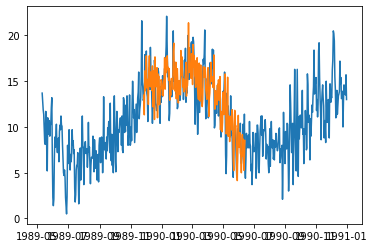

In [188]:
print("MSE: ", mean_squared_error(y.Temp[-400:-200], predictions))
print("MAE: ", mean_absolute_error(y.Temp[-400:-200], predictions))
plt.plot(y.Temp[-600:])
plt.plot(predictions)

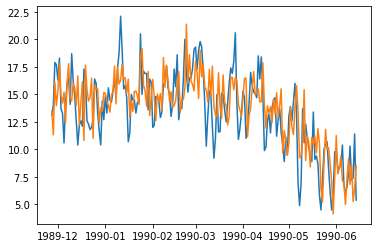

In [189]:
plt.plot(y.Temp[-400:-200])
plt.plot(predictions)

In [200]:
y.Temp[-400:-200]

date
1989-11-27    13.1
1989-11-28    14.0
1989-11-29    17.9
1989-11-30    17.7
1989-12-01    16.3
              ... 
1990-06-10    10.3
1990-06-11     7.2
1990-06-12     7.4
1990-06-13    11.4
1990-06-14     5.4
Name: Temp, Length: 200, dtype: float64

In [201]:
predictions

date
1989-11-27    13.462134
1989-11-28    11.328073
1989-11-29    16.130139
1989-11-30    13.968030
1989-12-01    15.371778
                ...    
1990-06-10     6.818479
1990-06-11     8.661018
1990-06-12     5.270227
1990-06-13     6.492869
1990-06-14     8.514852
Length: 200, dtype: float64

mean : -0.2960584129381348


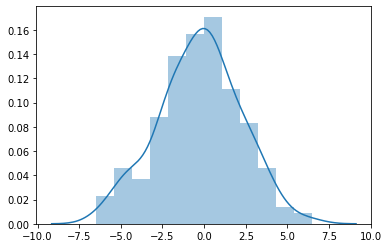

In [203]:
print('mean :', (y.Temp[-400:-200]- predictions).mean())
sns.distplot(y.Temp[-400:-200]- predictions)

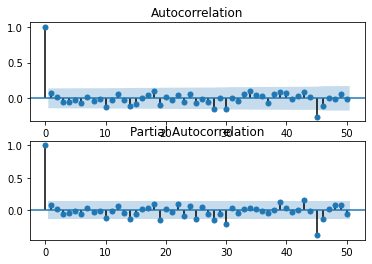

In [226]:
plt.figure()
plt.subplot(211)
plot_acf(y.Temp[-400:-200]- predictions, ax=plt.gca(), lags = 50)
plt.subplot(212)
plot_pacf(y.Temp[-400:-200]- predictions, ax=plt.gca(), lags = 50)
plt.show()

==> White noise 

Which one to choose ? 
- In order to do so, you have to choose the same train/test set or crossvalidation folds for all the same models, the score on which we can select the final model can be the MSE, MAE ...etc depending on the importance of outliers for example, we can also privilege models with an interval of residuals thinner...etc